In [53]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pathlib import Path

In [54]:
path = Path("Data")
xlsx_path = (path / "Bond_prices.xlsx").as_posix()

In [55]:
raw_data = pd.read_excel(xlsx_path)
df = raw_data[['Coupon', 'Maturity', 'Price']]
df = df.dropna()
df = df[~((df["Coupon"] > 0) & (df["Maturity"] < 2))]
df.head()

,Coupon,Maturity,Price
0,0.0,0.07940,99.847902
2,0.0,0.12594,99.719558
4,0.0,0.16427,99.630643
6,0.0,0.24641,99.443008
8,0.0,0.29021,99.326773


In [56]:
principal = 100
div_freq = 4

In [57]:
def spot_no_coupon(price, maturity):
    return -np.log(price / principal) / maturity

In [58]:
for index, row in df.iterrows():
    if row['Coupon'] == 0:
        df.at[index, 'Spot_Rate'] = spot_no_coupon(row['Price'], row['Maturity'])
    else:
        df.at[index, 'Spot_Rate'] = np.nan

In [59]:
def bond_ytm(ytm, coupon, maturity, price):
    cash_flows = np.array([coupon / div_freq] * int(maturity * div_freq))
    cash_flows[-1] += principal
    discount_factors = np.exp(-ytm * np.arange(1, len(cash_flows) + 1) / div_freq)
    return np.sum(cash_flows * discount_factors) - price

In [60]:
df['YTM'] = df.apply(lambda row: opt.root_scalar(bond_ytm, args=(row['Coupon'], row['Maturity'], row['Price']), 
                                                        bracket=[-0.1, 0.1], method='brentq').root if row['Coupon'] > 0 else np.nan, axis=1)

In [61]:
def svensson(TTM, beta0, beta1, beta2, beta3, tau1, tau2):
    term_1 = (1 - np.exp(-TTM / tau1)) / (TTM / tau1)
    term_2 = term_1 - np.exp(-TTM / tau1)
    term_3 = (1 - np.exp(-TTM / tau2)) / (TTM / tau2) - np.exp(-TTM / tau2)
    

    return beta0 + beta1 * term_1 + beta2 * term_2 + beta3 * term_3

In [62]:
def objective(params, maturities, zero_rates):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    return np.sum((svensson(maturities, beta0, beta1, beta2, beta3, tau1, tau2) - zero_rates) ** 2)

In [63]:
initial_guess = [0.03, -0.01, -0.01, 0.01, 2.0, 2.0]
maturities = df['Maturity'].values
spot_rates = np.where(df['Coupon'] == 0, df['Spot_Rate'], df['YTM'])
optimal_param = opt.minimize(objective, initial_guess, args=(maturities, spot_rates)).x

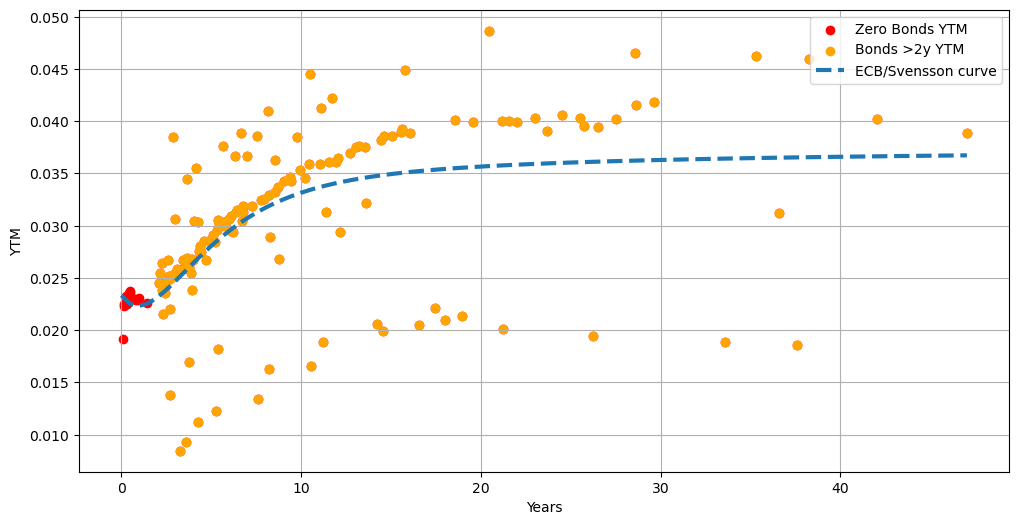

[ 0.03751405 -0.01415339 -2.81763434  2.80388859  2.36450979  2.37498187]


In [64]:
T_range = np.linspace(0.01, max(maturities), 100)
spot_curve = svensson(T_range, *optimal_param)

plt.figure(figsize=(12,6))
plt.scatter(maturities, spot_rates, color='red', label='Zero Bonds YTM')
plt.scatter(maturities, df['YTM'], color='orange', label='Bonds >2y YTM')
plt.plot(T_range, spot_curve, label='ECB/Svensson curve', linestyle='--', linewidth=3)
plt.xlabel('Years')
plt.ylabel('YTM')
plt.legend(loc='best')
plt.grid()
plt.show()

print(optimal_param)

## Bibliography

1) ESTIMATING AND INTERPRETING FORWARD INTEREST RATES: SWEDEN 1992-1994, Lars E. 0. Svensson

https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf

2) Euro area yield curves - technical notes

https://www.nber.org/system/files/working_papers/w4871/w4871.pdf
